To wrap up the semester, we will be looking at large pre-trained models. Recently, the very state-of-the-art models have gotten so large that you can't run them on anything but the most expensive GPUs.

Here we'll use a model released from Facebook/Meta a few years ago called BART: https://arxiv.org/pdf/1910.13461.pdf
BART was pre-trained on a combination of a large collection of books and (the entirety of the English-language) Wikipedia. BART is a transformer-based model that was intended to be used as pre-training for model weights that later get updated via supervised fine-tuning.

Rather than using BART directly, we will be using a version of BART that has been fine-tuned on Natural Language Inference (NLI) tasks called BART-NLI (https://huggingface.co/facebook/bart-large-mnli). These are tasks where the model has to classify whether or not a hypothesis (e.g., "the person is wet") follows from a given premise ("the person went swimming"). Yi et al. showed that BART, fine-tuned on NLI-style tasks, could be used to get surprisingly reasonable accuracy on many brand-new classification tasks. The process of doing well on problems without any training is called Zero-Shot Learning, and BART-NLI does an impressive job at Zero-Shot Classification tasks.

## Set-up

We will use the Hugging-face Transformer Library, which we first need to install:

In [1]:
!pip install transformers

# Song Classification

As an example of how we can use a zero-shot classifier, we'll try to classify Beatles songs as one of three types: Happy Songs, Sad Songs, and Weird Songs. The plan is to classify a song based on its lyrics -- my expectation is that their early songs will be happy, their later work a bit sadder, and their songs around the 1967 LSD/Transcendental period to be weird.

## Loading the Model

Here we will make use of the BART-MNLI zero-shot classifier. This is a transformer that has been trained on a large dataset and is capable of computing the relationship between any two phrases.

We'll use the HuggingFace Transformer's `pipeline` class to set up and create the zero-shot classification model.

In [25]:
from transformers import pipeline

#classifier = pipeline("zero-shot-classification") #Defaults to bart-large-mnli
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v1")
# bart_model = pipeline(model="facebook/bart-large-mnli")

In [22]:
import pandas as pd

# Since the file is a screenshot, we'll manually extract the data shown in the image
# Normally, we would load the CSV file directly, but as the file uploaded is an image, we manually transcribe the data
# This is a reconstruction of the data as shown in the provided screenshot

data = {
    "Problem": [
        "Conflict with a coworker", "Payroll discrepancy", "Request for leave",
        "Workplace harassment", "Benefits inquiry", "Performance review feedback",
        "Project assignment clarification", "Technical equipment issues", "Training and development",
        "Career advancement advice", "Work-life balance concerns", "Interdepartmental communication",
        "Feedback on company policies", "Health and safety concerns", "Ethical concerns or dilemmas",
        "Legal compliance questions", "Strategic business advice", "Major project roadblocks",
        "Budget allocation concerns", "High-level conflict resolution", "Company-wide communication",
        "Crisis management", "Major IT system changes", "Personal development plans",
        "Relocation assistance", "Workplace accessibility issues", "Change in personal circumstances",
        "Feedback on team dynamics", "Request for additional resources", "Long-term business strategy input"
    ],
    "Contact": [
        "HR Representative", "HR Representative", "HR Representative",
        "HR Representative", "HR Representative", "Team Leader",
        "Team Leader", "Team Leader", "HR Representative",
        "HR Representative", "HR Representative", "Team Leader",
        "HR Representative", "HR Representative", "Managing Partner",
        "Managing Partner", "Managing Partner", "Managing Partner",
        "Managing Partner", "Managing Partner", "Managing Partner",
        "Managing Partner", "Team Leader", "HR Representative",
        "HR Representative", "HR Representative", "HR Representative",
        "Team Leader", "Team Leader", "Managing Partner"
    ]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Now we have a DataFrame similar to the one that would be created from the CSV
# Display the DataFrame to ensure it's correct
df.head()

,Problem,Contact
0,Conflict with a coworker,HR Representative
1,Payroll discrepancy,HR Representative
2,Request for leave,HR Representative
3,Workplace harassment,HR Representative
4,Benefits inquiry,HR Representative


In [26]:
unique_contacts = df['Contact'].unique()
candidate_labels = [f"Problem to be taken up with {contact}" for contact in unique_contacts]

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

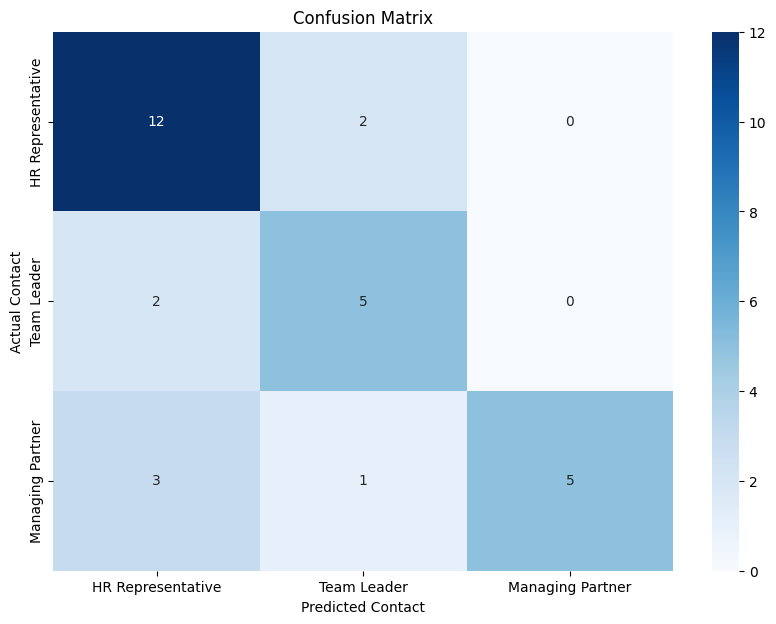

0.7333333333333333

In [28]:
predictions = []
for index, row in df.iterrows():
    # Classify the 'Problem' text
    result = classifier(row['Problem'], candidate_labels)
    # Get the best matching label
    predictions.append(result['labels'][0])

# Convert descriptive predictions to original contact labels for comparison
# This maps the prediction back to the original label (e.g., "HR Representative")
prediction_labels = [label.split(' with ')[-1] for label in predictions]

# Calculate the accuracy
accuracy = accuracy_score(df['Contact'], prediction_labels)

# Create a confusion matrix
conf_matrix = confusion_matrix(df['Contact'], prediction_labels, labels=unique_contacts)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_contacts, yticklabels=unique_contacts)
plt.ylabel('Actual Contact')
plt.xlabel('Predicted Contact')
plt.title('Confusion Matrix')
plt.show()

accuracy

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(df['Contact'], prediction_labels, average='weighted')

# Print out the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.73
Precision: 0.78
Recall: 0.73
F1 Score: 0.73


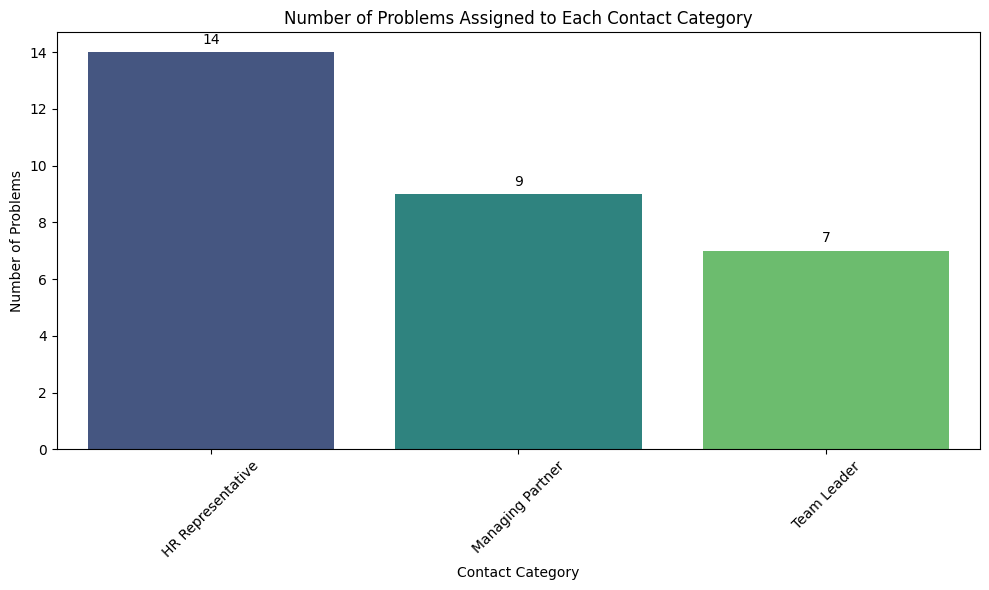

In [29]:
contact_counts = df['Contact'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=contact_counts.index, y=contact_counts.values, palette="viridis")

# Adding labels and title to the plot
plt.title('Number of Problems Assigned to Each Contact Category')
plt.xlabel('Contact Category')
plt.ylabel('Number of Problems')
plt.xticks(rotation=45)  # Rotate the labels on x-axis for better readability

# Adding the count above the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()

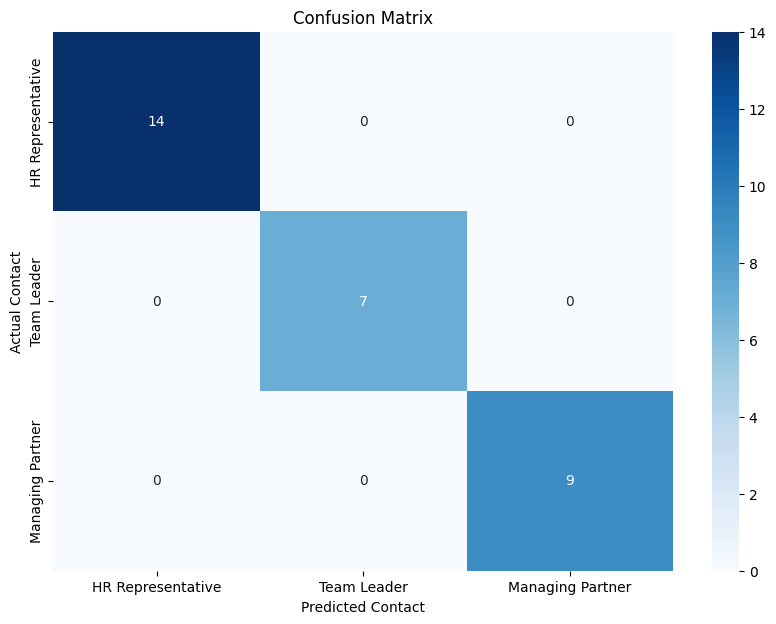

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# These are the predicted labels from GPT-4
gpt4_predictedlabels = [
    "HR Representative", "HR Representative", "HR Representative",
    "HR Representative", "HR Representative", "Team Leader",
    "Team Leader", "Team Leader", "HR Representative",
    "HR Representative", "HR Representative", "Team Leader",
    "HR Representative", "HR Representative", "Managing Partner",
    "Managing Partner", "Managing Partner", "Managing Partner",
    "Managing Partner", "Managing Partner", "Managing Partner",
    "Managing Partner", "Team Leader", "HR Representative",
    "HR Representative", "HR Representative", "HR Representative",
    "Team Leader", "Team Leader", "Managing Partner"
]

# Assuming df['Contact'] contains the true labels
# Calculate the accuracy
accuracy = accuracy_score(df['Contact'], gpt4_predictedlabels)

# Create a confusion matrix
unique_contacts = df['Contact'].unique()
conf_matrix = confusion_matrix(df['Contact'], gpt4_predictedlabels, labels=unique_contacts)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_contacts, yticklabels=unique_contacts)
plt.ylabel('Actual Contact')
plt.xlabel('Predicted Contact')
plt.title('Confusion Matrix')
plt.show()

# Display the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(df['Contact'], gpt4_predictedlabels, average='weighted')

# Print out the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


gpt4_predictedlabels = [
    "HR Representative", # Conflict with a coworker
    "HR Representative", # Payroll discrepancy
    "HR Representative", # Request for leave
    "HR Representative", # Workplace harassment
    "HR Representative", # Benefits inquiry
    "HR Representative", # Performance review feedback
    "Team Leader",       # Project assignment clarification
    "Team Leader",       # Technical equipment issues
    "Team Leader",       # Training and development
    "Team Leader",       # Career advancement advice
    "Team Leader",       # Work-life balance concerns
    "Team Leader",       # Interdepartmental communication
    "HR Representative", # Feedback on company policies
    "HR Representative", # Health and safety concerns
    "HR Representative", # Ethical concerns or dilemmas
    "HR Representative", # Legal compliance questions
    "Managing Partner",  # Strategic business advice
    "Managing Partner",  # Major project roadblocks
    "Managing Partner",  # Budget allocation concerns
    "Managing Partner",  # High-level conflict resolution
    "Managing Partner",  # Company-wide communication
    "Managing Partner",  # Crisis management
    "Managing Partner",  # Major IT system changes
    "Managing Partner",  # Personal development plans
    "Managing Partner",  # Relocation assistance
    "HR Representative", # Workplace accessibility issues
    "HR Representative", # Change in personal circumstances
    "Team Leader",       # Feedback on team dynamics
    "Team Leader",       # Request for additional resources
    "Managing Partner",  # Long-term business strategy input
]

## Classification [First Attempt]

We can use the bart-nli zero-shot classification model to measure the similarity between a chunk of the lyrics and the words `happy`, `sad`, and `weird`.

## Making this better

This demo is just a start to illustrate the key ideas of BART, Transformers, Huggin-face, and Zero-Shot learning. If you are going to try to pursue your final project along these lines, there are some very important issues I didn't really address here:

1. I think this dataset is too small. The Beatles have over 200 songs, so I should probably include more than just 9 of them. I don't think you need to test every song, but you would ideally have some reason for the ones you choose to include/exclude.

2. I hand-picked a few impactful famous songs. The work might be more interesting if I included every song released in a certain period or on a certain album.

3. I am only using a small, hand-picked part of the lyrics for each song. Better would be to use the entire lyrics in some way. But, I'm not sure if the best idea is to feed in all the lyrics to BART at once. More interesting might be to automatically split the lyrics into 4 or 5 parts, run the BART classifier on each part separately, and vote to find the final label.

4. I didn't explore a very specific, clear hypothesis, and I don't have any visual elements. What might be interesting is to plot the trend over time. For example, for each clear look at the percentage of the lines of lyrics that where happy vs. sad vs. weird and see if there is or is not a trend over time.